# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'Amir Malekhosseini'
std_number = '401100528'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [ ]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    # Normalize the input data
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    # Scale and shift the normalized data
    x_scaled_shifted = gamma * x_normalized + beta
    return x_scaled_shifted


In [ ]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [3]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
indices = np.arange(len(train_set) // 2)
train_subset = Subset(train_set, indices)
train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=64, shuffle=False, num_workers=2)


# VALIDATION DATA (Using half of the original validation set)
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=2)

# TEST DATA (Using half of the original test set)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

test_loader = DataLoader(
    test_set, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*answer*<br/><br/>
In transform_train we first randomly crops a section of the image and resizes it to 224x224 pixels. Then randomly flips the image horizontally with a 50% probability.
This is another data augmentation technique that helps the model learn features that are invariant to horizontal flips, improving generalization.<br/>
In transform_test we first resizes the image to 224x224 pixels.
Unlike RandomResizedCrop, it simply resizes the image without any random cropping.Then Converts the PIL Image to a PyTorch tensor, similar to transform_train.<br/>
In other words , transform_train includes data augmentation techniques (random cropping and horizontal flipping) to make the model more robust.<br/>
transform_test only resizes the images and normalizes the pixel values without any random transformations

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].


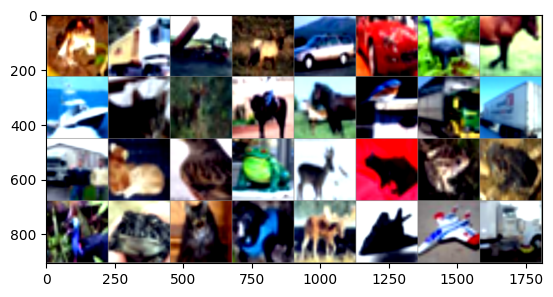

Labels are:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].


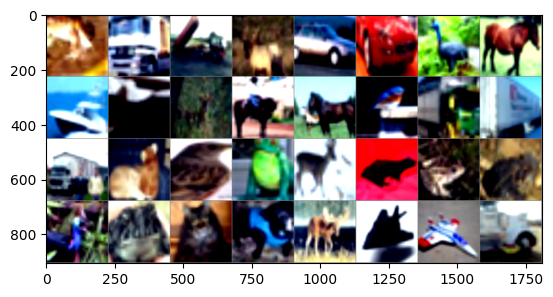

Labels are:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


In [4]:
def imshow(img):
    # TODO:
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show some training images with shuffle=False and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
print('Labels are: ', labels[:32])  # Print the label tensor
# print(' '.join(f'{train_set.classes[labels[j]]:5s}' for j in range(32)))

# show them again to check the augmentation
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
print('Labels are: ', labels[:32])  # Print the label tensor
# print(' '.join(f'{train_set.classes[labels[j]]:5s}' for j in range(32)))

# create train loader with shuffle true
train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=64, shuffle=True, num_workers=2)


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [5]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    losses = []

    # Set model to training or evaluation mode
    if train_mode:
        model.train()
    else:
        model.eval()

    with tqdm(data_loader, unit="batch") as tepoch:
      for inputs, targets in tepoch:
          inputs, targets = inputs.to(device), targets.to(device)

          # Forward pass
          with torch.set_grad_enabled(train_mode):
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              losses.append(loss.item())

              if train_mode:
                  # Backward pass and optimization
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

              tepoch.set_postfix(loss=loss.item())

    return losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        epoch_train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.extend(epoch_train_losses)  # Accumulate training losses

        epoch_val_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.extend(epoch_val_losses)  # Accumulate validation losses

        torch.cuda.empty_cache()

    torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()  # Increment number of correct predictions

    accuracy = 100 * correct / total
    return accuracy



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    kernel = np.ones(c_window) / c_window
    smoothed_train_losses = np.convolve(train_losses, kernel, mode='same')

    # Plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**<br/><br/>
In a standard convolution, a single filter is applied across all input channels to produce a single output channel. If we have D_K as the kernel size (e.g., 3 for a 3x3 kernel), M as the number of input channels, and N as the number of output channels, then the total number of parameters in a standard convolutional layer is:<br/>
Parameters = D_K * D_K * M * N <br/>
A DSC splits the convolution into two steps:<br/>
Depthwise Convolution: Applies a single filter to each input channel independently. The number of parameters in this step is:<br/>
Parameters_dw = D_K * D_K * M<br/>
Pointwise Convolution: Uses 1x1 convolutions to combine the output channels from the depthwise convolution. The number of parameters in this step is:<br/>
Parameters_pw = M * N<br/>
So the total parameters for DSC is:<br/>
Parameters_dsc = Parameters_dw + Parameters_pw = D_K * D_K * M + M * N<br/>
So the number of parameters in a DSC is significantly lower than in a standard convolution, especially when the number of output channels N is large.<br/>
DSCs not only reduce the number of parameters but also the number of computations required during the convolution operation. This leads to faster inference times. The reduction in computations is primarily due to the separation of the spatial and channel-wise filtering operations.


Now please create your model.

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3

model = MobileNet(n_class=10).to(device)

start_time = time.time()
train_losses, val_losses = train(train_loader, test_loader, model, epochs, lr)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 6/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 7/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 8/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 9/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 10/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Training time: 3903.18 seconds


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 79.48
Process validation time: 49.4656 s


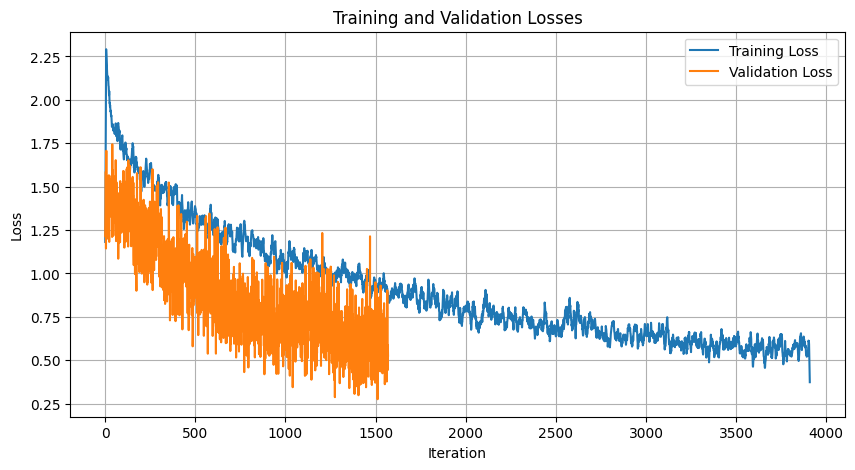

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**<br/><br/>
For a standard convolution with kernel size D_K, input channels M, output channels N, input feature map size D_F, the total number of FLOPs is:<br/>
FLOPs_standard = D_K * D_K * M * N * D_F * D_F<br/>
For a depthwise separable convolution with the same parameters, the FLOPs are calculated as follows:<br/>
FLOPs_dsc = FLOPs_dw + FLOPs_pw = D_K * D_K * M * D_F * D_F + M * N * D_F * D_F<br/>
In the MobileNet paper, they typically use N = 32 (or larger) for the number of output channels. Plugging this value into the above equation, we get:<br/>
FLOPs_standard / FLOPs_dsc = (9 * 32) / (9 + 32) ≈ 8.4<br/>
This means that a depthwise separable convolution with 32 output channels requires approximately 8.4 times fewer FLOPs compared to a standard convolution with the same configuration.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
# TODO: train model

epochs = 2
lr = 1e-3

model_normal = NormalCNN(n_class=10).to(device)

start_time = time.time()
train_losses, val_losses = train(train_loader, val_loader, model_normal, epochs, lr)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


Epoch 1/2


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/2


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Training time: 1797.67 seconds


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 34.18
Process validation time: 76.3056 s


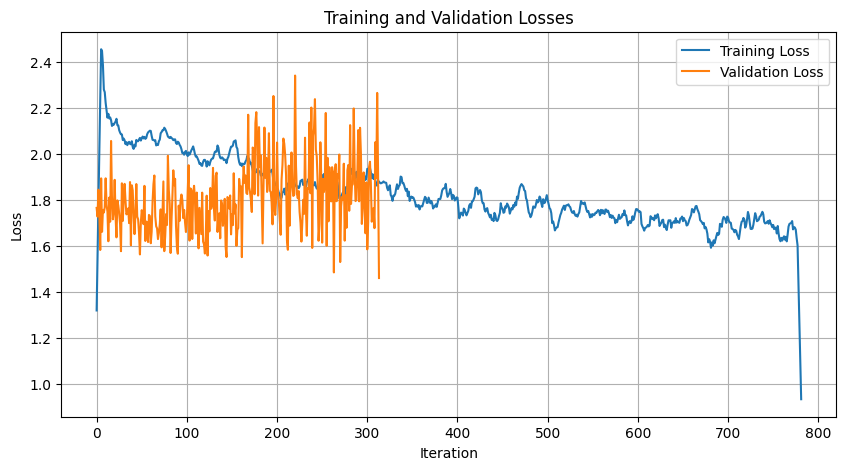

In [ ]:
start = time.time()
val_acc = get_acc(model_normal, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**<br/>

  Learning Speed: MobileNets generally learn faster than normal CNNs due to the reduced number of parameters and computations.<br/>
  Validation Speed: MobileNets also have faster validation times compared to normal CNNs for the same reason.


In [ ]:
# TODO: compare number of parameters in these two models

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


mobilenet_params = count_parameters(model)
normalcnn_params = count_parameters(model_normal)

print(f"MobileNet Parameters: {mobilenet_params}")
print(f"NormalCNN Parameters: {normalcnn_params}")

MobileNet Parameters: 3309476
NormalCNN Parameters: 28279338


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [ ]:
model = MobileNet(n_class=100).to(device)

# Load the pre-trained weights
pretrained_dict = torch.load('model.pt')

# Filter out unnecessary keys (fc layer)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}

# Modify the keys to match the new model's expected key format
modified_dict = {}
for k, v in pretrained_dict.items():

    modified_key = k.replace('.', '.0.')
    modified_dict[modified_key] = v

# Load the modified state dict into the model
model.load_state_dict(modified_dict, strict=False)




_IncompatibleKeys(missing_keys=['model.0.0.weight', 'model.0.1.weight', 'model.0.1.bias', 'model.0.1.running_mean', 'model.0.1.running_var', 'model.1.0.weight', 'model.1.1.weight', 'model.1.1.bias', 'model.1.1.running_mean', 'model.1.1.running_var', 'model.1.3.weight', 'model.1.4.weight', 'model.1.4.bias', 'model.1.4.running_mean', 'model.1.4.running_var', 'model.2.0.weight', 'model.2.1.weight', 'model.2.1.bias', 'model.2.1.running_mean', 'model.2.1.running_var', 'model.2.3.weight', 'model.2.4.weight', 'model.2.4.bias', 'model.2.4.running_mean', 'model.2.4.running_var', 'model.3.0.weight', 'model.3.1.weight', 'model.3.1.bias', 'model.3.1.running_mean', 'model.3.1.running_var', 'model.3.3.weight', 'model.3.4.weight', 'model.3.4.bias', 'model.3.4.running_mean', 'model.3.4.running_var', 'model.4.0.weight', 'model.4.1.weight', 'model.4.1.bias', 'model.4.1.running_mean', 'model.4.1.running_var', 'model.4.3.weight', 'model.4.4.weight', 'model.4.4.bias', 'model.4.4.running_mean', 'model.4.4.r

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [ ]:
# Freeze up to the desired layer (e.g., the first 7 layers)

for i, child in enumerate(model.model.children()):  # model.model is the feature extraction part
    if i < 7:
        for param in child.parameters():
            param.requires_grad = False


**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [ ]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


0it [00:00, ?it/s]

Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].


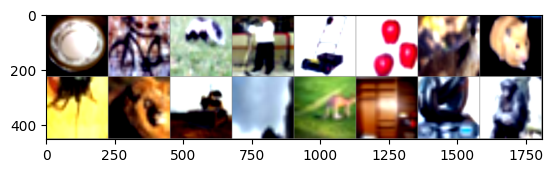

Labels are:  tensor([10,  8, 75, 46, 41,  0, 38, 36, 24, 43, 89, 76, 38, 94, 40, 21])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.5126765].


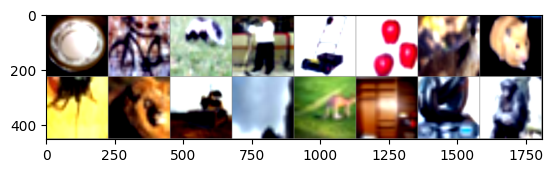

Labels are:  tensor([10,  8, 75, 46, 41,  0, 38, 36, 24, 43, 89, 76, 38, 94, 40, 21])


In [ ]:
# show some training images with shuffle=False and labels
dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print('Labels are: ', labels[:16])  # Print the label tensor

# show them again to check the augmentation
dataiter = iter(train_loader100)
# images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print('Labels are: ', labels[:16])  # Print the label tensor


Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**<br/><br/>
CIFAR-10 and CIFAR-100 do not use the exact same set of images but share many similarities. Both datasets contain 60,000 color images (32x32 pixels), split into 50,000 training images and 10,000 test images. However, the classification labels differ significantly:

CIFAR-10: Contains 10 mutually exclusive classes (e.g., airplane, car, bird), with 6,000 images per class.<br/>
CIFAR-100: Contains 100 fine-grained classes (e.g., specific animal or object types) and also groups these into 20 superclasses for broader categorization. Each class in CIFAR-100 has 600 images: 500 for training and 100 for testing.<br/>
Task Complexity: CIFAR-100 is considered a more challenging dataset due to the larger number of classes and finer-grained distinctions between them.


Now train your model using your functions.

In [ ]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 2/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 3/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 4/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 5/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 6/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Epoch 7/7


  0%|          | 0/157 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 21.1
Process validation time: 35.7725 s


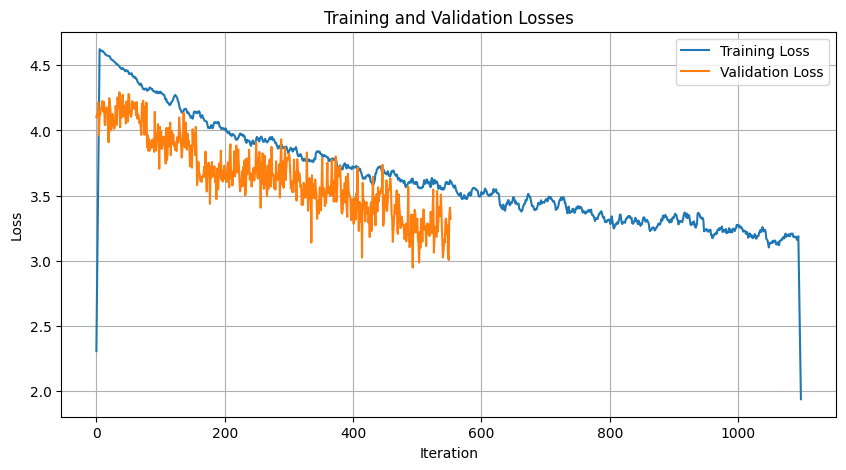

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**<br/><br/>

ReLU6 is a variant of ReLU that limits the output to a maximum of 6. It is used in MobileNetV2 to improve performance and robustness on mobile and embedded devices, where quantization and low-precision arithmetic are common. Its bounded output range helps with quantization, prevents numerical instability, and makes the model more efficient for mobile deployment.

In [11]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Inverted Residual block with optional skip connection.
        Args:
            inp: Input channels.
            oup: Output channels.
            stride: Stride for depthwise convolution.
            expand_ratio: Multiplier for the hidden dimension size.
        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_residual = (self.stride == 1 and inp == oup)

        layers = []
        if expand_ratio == 1:
            layers.extend([
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),

                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            ])
        else:
            layers.extend([
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),

                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),

                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass with optional residual connection.
        """
        if self.use_residual:
            return x + self.conv(x)  # Residual connection
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=0.1):

        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]

        # building first layer
        input_channel = int(input_channel * width_multiplier)
        layers_features = [conv_bn(3, input_channel, 2)]
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                if i == 0:
                    layers_features.append(InvertedResidual(
                        input_channel, output_channel, s, expand_ratio=t))
                else:
                    layers_features.append(InvertedResidual(
                        input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel

        last_channel = last_channel if width_multiplier >= 1.0 else int(
            last_channel * width_multiplier)
        layers_features.append(conv_1x1_bn(input_channel, last_channel))
        self.features = nn.Sequential(*layers_features)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(last_channel, n_class)

        for i in self.modules():
            if isinstance(i, nn.Conv2d):
                nn.init.kaiming_normal_(i.weight, mode='fan_out')
            elif isinstance(i, nn.BatchNorm2d):
                nn.init.ones_(i.weight)
                nn.init.zeros_(i.bias)
            elif isinstance(i, nn.Linear):
                nn.init.normal_(i.weight, 0, 0.01)
                nn.init.zeros_(i.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


**answer**<br/><br/>

Linear bottlenecks are an essential design choice for lightweight architectures like MobileNetV2. They work by balancing the trade-offs between preserving useful information and minimizing computational overhead. By combining expansion, depthwise separable convolution, and linear projection, they enable high-performance models that are computationally efficient and suitable for mobile and embedded applications.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [18]:
torch.cuda.empty_cache()
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


Epoch 1/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 2/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 3/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 4/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 5/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 6/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 7/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 8/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 9/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 10/10


  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/157 [00:00<?, ?batch/s]

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 51.85
Process validation time: 16.7708 s


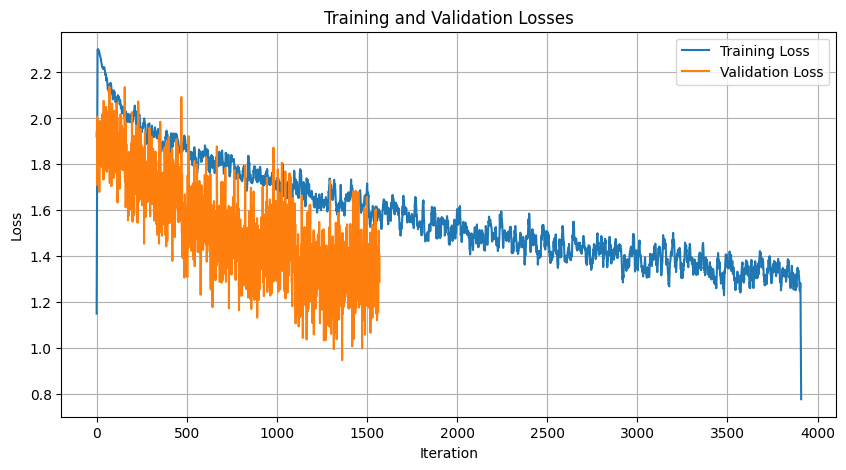

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [13]:
# TODO
width_multipliers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for width_multiplier in width_multipliers:
    model = MobileNetV2(width_multiplier=width_multiplier)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Width Multiplier: {width_multiplier}, Number of Parameters: {num_params}")


Width Multiplier: 0.1, Number of Parameters: 158965
Width Multiplier: 0.2, Number of Parameters: 359654
Width Multiplier: 0.3, Number of Parameters: 602826
Width Multiplier: 0.4, Number of Parameters: 888308
Width Multiplier: 0.5, Number of Parameters: 1221768
Width Multiplier: 0.6, Number of Parameters: 1588253
Width Multiplier: 0.7, Number of Parameters: 2001198
Width Multiplier: 0.8, Number of Parameters: 2456538
Width Multiplier: 0.9, Number of Parameters: 2954276
Width Multiplier: 1.0, Number of Parameters: 3504872


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [16]:
from collections import OrderedDict



MNv2_path = './MNv2WMmodel.pt'

# Load the pretrained model with width_multiplier=0.5
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
model.load_state_dict(torch.load(MNv2_path, map_location=device))

# Evaluate accuracy and measure validation time for the width_multiplier=0.5 model
start_time = time.time()
acc_wm = get_acc(model, test_loader)
end_time = time.time()
time_wm = end_time - start_time
print(
    f"Width multiplier=0.5 model: Accuracy = {acc_wm:.2f}%, Validation Time = {time_wm:.4f}s")

model_normal = MobileNetV2(n_class=10, width_multiplier=1.0).to(device)

start_time = time.time()
acc_normal = get_acc(model_normal, test_loader)
end_time = time.time()
time_normal = end_time - start_time
print(
    f"Width multiplier=1.0 model: Accuracy = {acc_normal:.2f}%, Validation Time = {time_normal:.4f}s")


Width multiplier=0.5 model: Accuracy = 74.32%, Validation Time = 18.3450s
Width multiplier=1.0 model: Accuracy = 10.05%, Validation Time = 27.6718s


In [17]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 74.32
Process validation time: 20.5364 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**<br/><br/>
The width multiplier (α) directly scales the number of channels in each layer of the MobileNetV2 architecture. This scaling affects the number of parameters in convolutional layers, which are the primary contributors to the overall parameter count.<br/>

Convolutional layers have parameters proportional to: (input channels * output channels * kernel size^2).<br/>
In MobileNetV2, the width multiplier (α) scales both input and output channels of the depthwise and pointwise convolutions within inverted residual blocks.<br/>
Therefore, the approximate effect on the number of parameters is:

New parameters ≈ α^2 * original parameters<br/>

When you printed the number of parameters for different width multipliers, there is a discrepancies compared to the formula above. This is because:

Not all layers are equally affected: The width multiplier primarily impacts convolutional layers. The fully connected layer at the end and batch normalization parameters have a smaller relative change.<br/><br/>
Rounding: The number of channels is rounded to integers after applying the width multiplier. This rounding introduces some error.<br/><br/>
Specific architecture: Certain layers in MobileNetV2 have fixed channel numbers, which are not scaled by the width multiplier.



Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**<br/><br/>

The resolution multiplier (ρ) is applied to the input image size. It scales the width and height of the input image, effectively changing the resolution at which the model operates.<br/>

the resolution multiplier can make the model faster. Here's because:<br/>

Reduced Computation: Lowering the input resolution decreases the number of pixels the model needs to process. This directly reduces the computational load in convolutional layers, leading to faster inference times.<br/>
Smaller Feature Maps: The intermediate feature maps within the network also become smaller with a reduced input resolution. This further reduces memory and computational requirements, leading to speed improvements.<br/>

On the other hand, the resolution multiplier does not directly decrease the number of parameters. The number of parameters in a convolutional layer is primarily determined by the number of input and output channels and the kernel size, which remain unchanged by the resolution multiplier.<br/>

So there is a trade-off between speed and accuracy when using the resolution multiplier. Lowering the resolution can significantly speed up inference but may come at the cost of reduced accuracy, as the model works with less detailed information.


Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**<br/><br/>

While GPUs accelerate training and inference, the number of parameters still significantly impacts memory usage, inference speed, training time, power consumption, and the risk of overfitting. Therefore, optimizing the number of parameters remains a critical aspect of building efficient and effective deep learning models.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [ ]:
import timm


# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 9.96
Process validation time: 18.3623 s


Now create a mobilenetv2 model and then write the code to

---

train it with Knowledge Distillation.

In [ ]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):

        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')  # KL divergence

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
          """
          Compute the combined distillation and classification loss.
          """
          # Scale logits with temperature
          student_logits_scaled = student_logits / self.temperature
          teacher_logits_scaled = teacher_logits / self.temperature

          # Soft targets from teacher
          teacher_probs = torch.softmax(teacher_logits_scaled, dim=1)
          student_log_probs = torch.log_softmax(student_logits_scaled, dim=1)

          # Distillation loss (KL Divergence between teacher and student logits)
          distillation_loss = self.kl_divergence(student_log_probs, teacher_probs) * (self.temperature ** 2)

          # Classification loss (CrossEntropy with hard labels)
          classification_loss = F.cross_entropy(student_logits, labels)

          # Combine the losses
          loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
          return loss



def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Get teacher and student outputs
            with torch.no_grad():
                teacher_logits = teacher(images)

            student_logits = student(images)

            # Compute distillation loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_loader):.4f}")

    # Evaluate on test set
    start = time.time()
    test_acc = get_acc(student, val_loader)
    end = time.time()

    print('Test accuracy =', test_acc)
    print("Process Test time: {:0.4f} s".format(end - start))


Train it for one epoch to just check if it works.

In [ ]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1, Training Loss: 1.1408
Test accuracy = 22.07
Process Test time: 17.8780 s


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**<br/><br/>
High Alpha (e.g., 0.9):<br/>

Emphasis: Focuses more on the teacher's soft predictions.<br/>
Benefits: Captures nuanced inter-class relationships and teacher's knowledge.<br/>
Risks: Overfits to teacher biases/errors; may reduce generalization if the teacher is misaligned with the target task.<br/>

Low Alpha (e.g., 0.1):<br/>

Emphasis: Focuses more on the true labels (hard labels).<br/>
Benefits: Better generalization to the target task; less reliance on the teacher's potential errors.<br/>
Risks: Misses out on nuanced inter-class relationships provided by the teacher.<br/>

Choosing Alpha:<br/>

Use high alpha if the teacher is accurate and the dataset is small/noisy.<br/>
Use low alpha if the dataset is large and reliable or the teacher is less aligned with the target task.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018